# Purpose

In this notebook, we train and evaluate 2 different kind of models:
- Random Forest
- MLPC
  
Both models are trained and evaluated using default hyperparameters **AND** optimized hyperparameters (Grid search).  
The data used ("rera.joblib") has been preprocessed in the preprocessing notebook.
  
In the end, the goal is to be able to choose the best model to predict match results during the competition.

# Import libraries and prepare data for training

In [6]:
# import library
import os

import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve

from joblib import dump, load

In [2]:
# import dataset
df = load("../assets/rera.joblib")
df.drop(["date"], axis = 1,  inplace=True)

In [3]:
df.head(10)

,home_team,away_team,neutral,rank_home,total_points_home,confederation_home,rank_away,total_points_away,confederation_away,winner,home_goals_avg,away_goals_avg,home_win_avg,away_win_avg,home_last_wins,away_last_wins
0,Panama,Guatemala,False,139.0,214.0,CONCACAF,73.0,454.0,CONCACAF,0,0.0,0.0,0.0,0.0,0,0
1,Togo,Egypt,False,87.0,413.0,CAF,38.0,558.0,CAF,0,0.0,0.0,0.0,0.0,0,0
2,Burkina Faso,Algeria,False,74.0,453.0,CAF,86.0,421.0,CAF,0,0.0,0.0,0.0,0.0,0,0
3,Malta,Qatar,False,116.0,308.0,UEFA,107.0,357.0,AFC,0,0.0,0.0,0.0,0.0,0,0
6,Egypt,Zambia,True,38.0,558.0,CAF,36.0,571.0,CAF,0,0.0,0.0,0.0,0.0,0,0
8,Nigeria,Tunisia,False,76.0,444.0,CAF,28.0,604.0,CAF,0,0.0,0.0,0.0,0.0,0,0
9,South Africa,Gabon,True,31.0,597.0,CAF,72.0,456.0,CAF,0,0.0,0.0,0.0,0.0,0,0
10,Vietnam,Guam,False,102.0,374.0,AFC,200.0,4.0,AFC,0,0.0,0.0,0.0,0.0,0,0
12,Qatar,Bosnia and Herzegovina,False,107.0,357.0,AFC,75.0,446.0,UEFA,0,0.0,0.0,0.0,0.0,0,0
14,Morocco,Congo,True,25.0,613.0,CAF,94.0,396.0,CAF,0,0.0,0.0,0.0,0.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18846 entries, 0 to 2982
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   home_team           18846 non-null  object 
 1   away_team           18846 non-null  object 
 2   neutral             18846 non-null  bool   
 3   rank_home           18846 non-null  float64
 4   total_points_home   18846 non-null  float64
 5   confederation_home  18846 non-null  object 
 6   rank_away           18846 non-null  float64
 7   total_points_away   18846 non-null  float64
 8   confederation_away  18846 non-null  object 
 9   winner              18846 non-null  int64  
 10  home_goals_avg      18846 non-null  float64
 11  away_goals_avg      18846 non-null  float64
 12  home_win_avg        18846 non-null  float64
 13  away_win_avg        18846 non-null  float64
 14  home_last_wins      18846 non-null  int64  
 15  away_last_wins      18846 non-null  int64  
dtypes: bool(1)

Quick check to see which country is missing from our dataset.

In [4]:
country_list = pd.read_csv("../data/FIFA_country_list.csv", sep=";", names=["Country"], index_col=False)
set(country_list["Country"].unique()) - set(df["home_team"].unique())

{'Chinese Taipei',
 'Curaçao',
 'DR Congo',
 'Eswatini',
 'Saint Kitts and Nevis',
 'Saint Lucia',
 'Saint Vincent and the Grenadines',
 'Timor-Leste',
 'Trinidad and Tobago',
 'U.S. Virgin Islands'}

Unfortunately, we won't be able to predict match results for these countries...

Dividing our data into two distinct sets: a training set, comprising 2/3 of the data, and a test set, comprising the remaining 1/3.

In [5]:
X = df.drop('winner', axis=1)  # X contains all columns except 'winner'
y = df['winner']  # y contains the 'winner' column = label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

# Random Forest Model

## Default hyperparameters

### Load the Random Forest model (default hyperparameters)

Run this cell and skip the next section if you don't want to train the model again.

In [7]:
clf = load("../assets/rf_clf_default_86_acc.joblib")

### Pipeline definition and training

In [19]:
numeric_features = ["rank_home", "total_points_home", "rank_away", "total_points_away", "home_goals_avg", "away_goals_avg", "home_win_avg", "away_win_avg", "home_last_wins", "away_last_wins"]
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_features = ["home_team", "away_team", "neutral", "confederation_home", "confederation_away"]
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown='ignore')),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier(random_state=42))]
)

clf.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['rank_home',
                                                   'total_points_home',
                                                   'rank_away',
                                                   'total_points_away',
                                                   'home_goals_avg',
                                                   'away_goals_avg',
                                                   'home_win_avg',
                                                   'away_win_avg',
                                                   'home_last_wins',
                                                   'away_last_wins']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['home_team', 'away_team',
                                                   'neutral',
                                                   'confederation_home',
                                                   'confederation_away'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

### Model evaluation

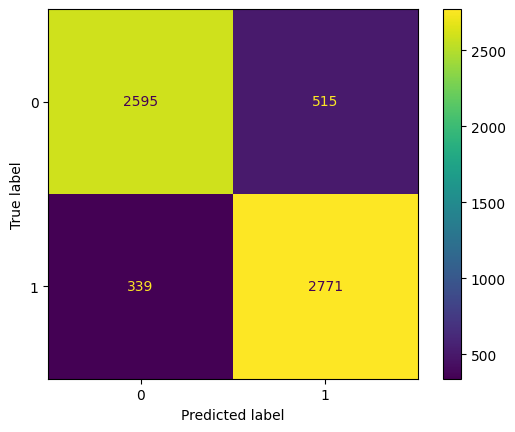

In [8]:
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.savefig("../img/confusion_matrices/confusion_matrix_rf_default_86_acc.png")
plt.show()

In [9]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.88      0.83      0.86      3110
           1       0.84      0.89      0.87      3110

    accuracy                           0.86      6220
   macro avg       0.86      0.86      0.86      6220
weighted avg       0.86      0.86      0.86      6220



### Learning curves

Plotting the learning curves to check if the model is not overfitting or underfitting.

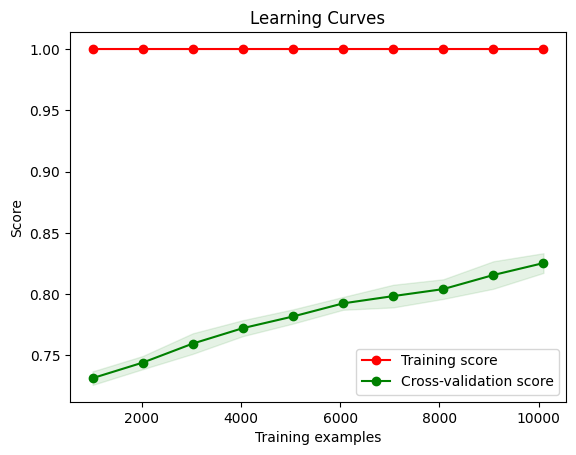

In [25]:
# Define the learning curve function
train_sizes, train_scores, validation_scores = learning_curve(
    estimator = clf, 
    X = X_train, 
    y = y_train, 
    train_sizes = np.linspace(0.1, 1.0, 10), 
    cv = 5, 
    scoring = 'accuracy',
    n_jobs=5
)

# Calculate the mean and standard deviation of the training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# Plot the learning curves
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curves")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.savefig("../img/learning_curves/learning_curves_rf_default_86_acc.png")
plt.show()

There is a non-negligeable gap between the validation and the train curves, suggesting a potential overfitting.  
It may be due to the random oversampling we used to balance classes. By duplicating data, we must have influenced the model to overfit. 
It's also possible that it's due to the fact that the Random Forest is too complex to represent the data we're using. 
  
As a consequence, it's likely that the model won't be able to generalize very well, even if the accuracy is high.  
To adress this issue, there are some avenues to explore:
- Use another method for oversampling to balance the classes (like SMOTE algorithm).
- Further fine-tune the model hyperparameters.
- Use a simpler model like Logistic Regression.  

### Export the pipeline in joblib format

In [26]:
# dump(clf, "../assets/rf_clf_default_86_acc.joblib")

['../assets/rf_clf_default_86_acc.joblib']

## Optimized hyperparameters (Grid search)

Here, we optimize the hyperparameters of the model using a grid search.

### Load optimized Random Forest model

Run this cell and skip the next section if you don't want to train the model again.

In [6]:
clf = load("../assets/rf_clf_gridsearch_86_acc.joblib")

### Pipeline definition and training

In [12]:
numeric_features = ["rank_home", "total_points_home", "rank_away", "total_points_away", "home_goals_avg", "away_goals_avg", "home_win_avg", "away_win_avg", "home_last_wins", "away_last_wins"]
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_features = ["home_team", "away_team", "neutral", "confederation_home", "confederation_away"]
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Parameters to optimize
parameters = {'max_depth':[10, 50, 100],
              'n_estimators':[50, 100, 500],
              'max_features': [None, 'sqrt', 'log2'] # Reducing the number of features considered could help avoid overfitting
            }

""" parameters = {'max_depth':[10, 50, 100],
              'n_estimators':[50, 100, 500],
            } """

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", GridSearchCV(RandomForestClassifier(random_state=42), parameters, n_jobs=5))]
)

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['rank_home',
                                                   'total_points_home',
                                                   'rank_away',
                                                   'total_points_away',
                                                   'home_goals_avg',
                                                   'away_goals_avg',
                                                   'home_win_avg',
                                                   'away_win_avg',
                                                   'home_last_wins',
                                                   'away_last_wins']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['home_team', 'away_team',
                                                   'neutral',
                                                   'confederation_home',
                                                   'confederation_away'])])),
                ('classifier',
                 GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                              n_jobs=5,
                              param_grid={'max_depth': [10, 50, 100],
                                          'max_features': [None, 'sqrt',
                                                           'log2'],
                                          'n_estimators': [50, 100, 500]}))])

In [13]:
clf["classifier"].best_params_

{'max_depth': 100, 'max_features': 'log2', 'n_estimators': 500}

### Model evaluation

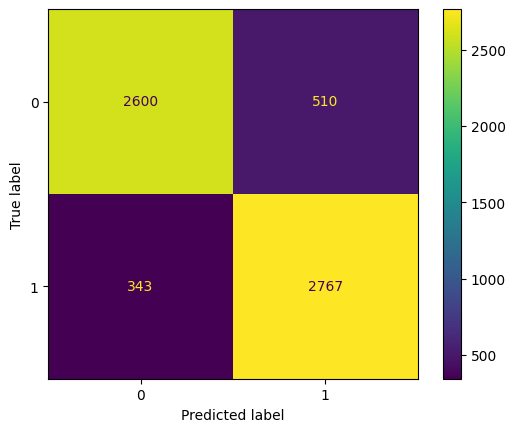

In [14]:
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.savefig("../img/confusion_matrices/confusion_matrix_rf_gridsearch_86_acc.png")
plt.show()

In [15]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      3110
           1       0.84      0.89      0.87      3110

    accuracy                           0.86      6220
   macro avg       0.86      0.86      0.86      6220
weighted avg       0.86      0.86      0.86      6220



### Learning curves

Plotting the learning curves to check if the model is not overfitting or underfitting.

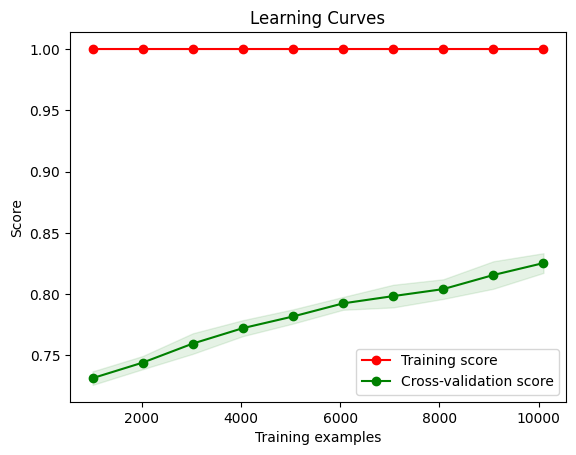

In [34]:
model = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier(random_state=42, n_estimators=clf["classifier"].best_params_["n_estimators"], max_depth=clf["classifier"].best_params_["max_depth"]))]
)
# Define the learning curve function
train_sizes, train_scores, validation_scores = learning_curve(
    estimator = model, 
    X = X_train, 
    y = y_train, 
    train_sizes = np.linspace(0.1, 1.0, 10), 
    cv = 5, 
    scoring = 'accuracy',
    n_jobs=5 
)

# Calculate the mean and standard deviation of the training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# Plot the learning curves
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curves")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.savefig("../img/learning_curves/learning_curves_rf_gridsearch_86_acc.png")
plt.show()

### Export the model in joblib format

In [35]:
# dump(clf, "../assets/rf_clf_gridsearch_86_acc.joblib")

['../assets/rf_clf_gridsearch_86_acc.joblib']

## PCA + Random Forest model

In this configuration, we perform a PCA for dimensionality reduction before training the model.

### Load the Randomf Forest model with PCA preprocessing

Run this cell and skip the next section if you don't want to train the model again.

In [142]:
clf = load("../assets/rf_clf_pca_default_86_acc.joblib")

### Pipeline definition and training

In [36]:
numeric_features = ["rank_home", "total_points_home", "rank_away", "total_points_away", "home_goals_avg", "away_goals_avg", "home_win_avg", "away_win_avg", "home_last_wins", "away_last_wins"]
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_features = ["home_team", "away_team", "neutral", "confederation_home", "confederation_away"]
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

pca_transformer = Pipeline(
    steps=[
        ("pca", PCA(n_components=5))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("pca", pca_transformer, numeric_features) # To be efficient, PCA should be applied only on numerical features 
    ]
)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier(random_state=42))]
)

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['rank_home',
                                                   'total_points_home',
                                                   'rank_away',
                                                   'total_points_away',
                                                   'home_goals_avg',
                                                   'away_goals_avg',
                                                   'home_win_avg',
                                                   'away_win_avg',
                                                   'home_last_wins',
                                                   'away_last_wins']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='igno...
                                                  ['home_team', 'away_team',
                                                   'neutral',
                                                   'confederation_home',
                                                   'confederation_away']),
                                                 ('pca',
                                                  Pipeline(steps=[('pca',
                                                                   PCA(n_components=5))]),
                                                  ['rank_home',
                                                   'total_points_home',
                                                   'rank_away',
                                                   'total_points_away',
                                                   'home_goals_avg',
                                                   'away_goals_avg',
                                                   'home_win_avg',
                                                   'away_win_avg',
                                                   'home_last_wins',
                                                   'away_last_wins'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

### Model evaluation

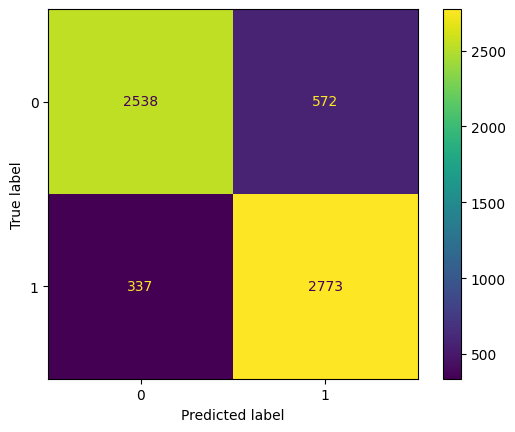

In [39]:
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.savefig("../img/confusion_matrices/confusion_matrix_rf_pca_85_acc.png")
plt.show()

In [40]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      3110
           1       0.83      0.89      0.86      3110

    accuracy                           0.85      6220
   macro avg       0.86      0.85      0.85      6220
weighted avg       0.86      0.85      0.85      6220



### Learning curves

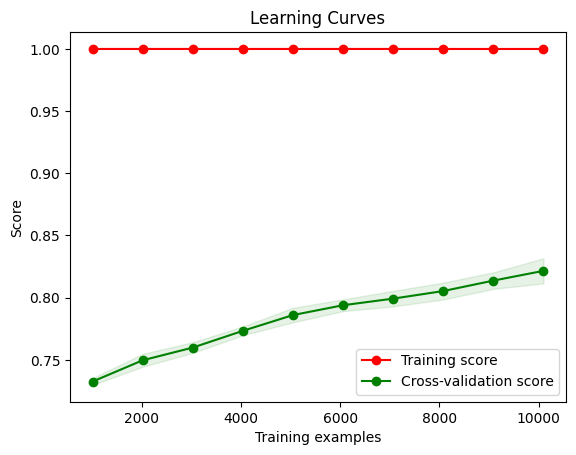

In [42]:
# Define the learning curve function
train_sizes, train_scores, validation_scores = learning_curve(
    estimator = clf, 
    X = X_train, 
    y = y_train, 
    train_sizes = np.linspace(0.1, 1.0, 10), 
    cv = 5, 
    scoring = 'accuracy',
    n_jobs=5
)

# Calculate the mean and standard deviation of the training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# Plot the learning curves
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curves")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.savefig("../img/learning_curves/learning_curves_rf_pca_85_acc.png")
plt.show()

### Export the model in joblib format

In [43]:
# dump(clf, "../assets/rf_clf_pca_default_85_acc.joblib")

['../assets/rf_clf_pca_default_85_acc.joblib']

# MLPC

## Default hyperparameters

### Load the MLPC model (default hyperparameters)

Run this cell and skip the next section if you don't want to train the model again.

In [12]:
clf = load("../assets/mlpc_clf_default_84_acc.joblib")

### Pipeline definition and training

In [44]:
numeric_features = ["rank_home", "total_points_home", "rank_away", "total_points_away", "home_goals_avg", "away_goals_avg", "home_win_avg", "away_win_avg", "home_last_wins", "away_last_wins"]
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_features = ["home_team", "away_team", "neutral", "confederation_home", "confederation_away"]
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown='ignore')),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", MLPClassifier(random_state=42))]
)

clf.fit(X_train, y_train)

/home/marouan/.local/share/virtualenvs/NN_project-jQMrRvsR/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['rank_home',
                                                   'total_points_home',
                                                   'rank_away',
                                                   'total_points_away',
                                                   'home_goals_avg',
                                                   'away_goals_avg',
                                                   'home_win_avg',
                                                   'away_win_avg',
                                                   'home_last_wins',
                                                   'away_last_wins']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['home_team', 'away_team',
                                                   'neutral',
                                                   'confederation_home',
                                                   'confederation_away'])])),
                ('classifier', MLPClassifier(random_state=42))])

### Model evaluation

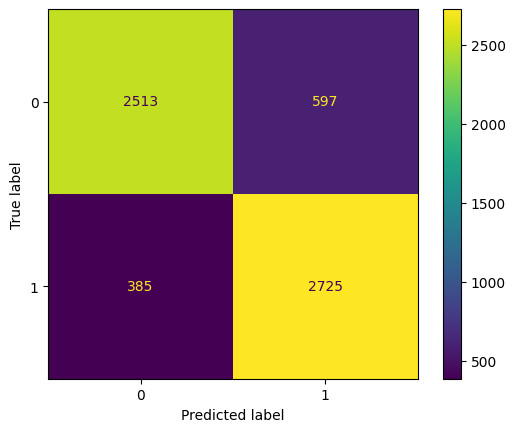

In [13]:
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.savefig("../img/confusion_matrices/confusion_matrix_mlpc_default_84_acc.png")
plt.show()

In [15]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      3110
           1       0.82      0.88      0.85      3110

    accuracy                           0.84      6220
   macro avg       0.84      0.84      0.84      6220
weighted avg       0.84      0.84      0.84      6220



### Learning curves

Plotting the learning curves to check if the model is not overfitting or underfitting.

/home/marouan/.local/share/virtualenvs/NN_project-jQMrRvsR/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/marouan/.local/share/virtualenvs/NN_project-jQMrRvsR/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/marouan/.local/share/virtualenvs/NN_project-jQMrRvsR/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/marouan/.local/share/virtualenvs/NN_project-jQMrRvsR/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochas

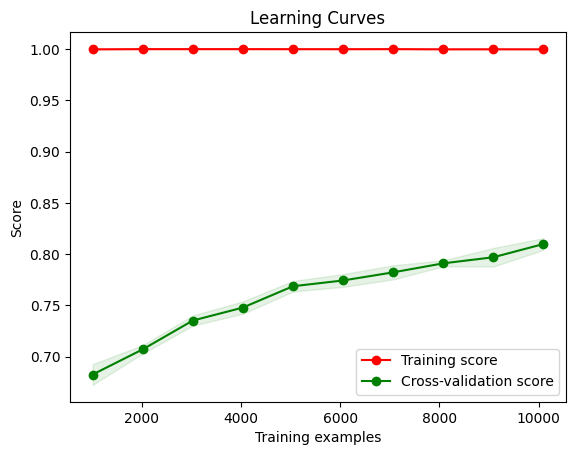

In [48]:
# Define the learning curve function
train_sizes, train_scores, validation_scores = learning_curve(
    estimator = clf, 
    X = X_train, 
    y = y_train, 
    train_sizes = np.linspace(0.1, 1.0, 10), 
    cv = 5, 
    scoring = 'accuracy',
    n_jobs=5 
)

# Calculate the mean and standard deviation of the training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# Plot the learning curves
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curves")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.savefig("../img/learning_curves/learning_curves_mlpc_default_84_acc.png")
plt.show()

The MLPC model has also a non negligible gap between learning curves...

### Export the pipeline in joblib format

In [49]:
# dump(clf, "../assets/mlpc_clf_default_84_acc.joblib")

['../assets/mlpc_clf_default_84_acc.joblib']

## Optimized hyperparameters (Grid search)

### Load the MLPC model (default hyperparameters)

Run this cell and skip the next section if you don't want to train the model again.

In [61]:
clf = load("../assets/mlpc_clf_gridsearch_84_acc.joblib")

### Pipeline definition and training

In [50]:
numeric_features = ["rank_home", "total_points_home", "rank_away", "total_points_away", "home_goals_avg", "away_goals_avg", "home_win_avg", "away_win_avg", "home_last_wins", "away_last_wins"]
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_features = ["home_team", "away_team", "neutral", "confederation_home", "confederation_away"]
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Parameters to optimize
parameters = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'alpha': [0.0001, 0.001, 0.01], # L2 regularization, larger values can help reducing overfitting
}

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", GridSearchCV(MLPClassifier(random_state=42), parameters, n_jobs=5))]
)

clf.fit(X_train, y_train)

/home/marouan/.local/share/virtualenvs/NN_project-jQMrRvsR/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/marouan/.local/share/virtualenvs/NN_project-jQMrRvsR/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/marouan/.local/share/virtualenvs/NN_project-jQMrRvsR/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/marouan/.local/share/virtualenvs/NN_project-jQMrRvsR/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochas

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['rank_home',
                                                   'total_points_home',
                                                   'rank_away',
                                                   'total_points_away',
                                                   'home_goals_avg',
                                                   'away_goals_avg',
                                                   'home_win_avg',
                                                   'away_win_avg',
                                                   'home_last_wins',
                                                   'away_last_wins']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['home_team', 'away_team',
                                                   'neutral',
                                                   'confederation_home',
                                                   'confederation_away'])])),
                ('classifier',
                 GridSearchCV(estimator=MLPClassifier(random_state=42),
                              n_jobs=5,
                              param_grid={'alpha': [0.0001, 0.001, 0.01],
                                          'hidden_layer_sizes': [(50,), (100,),
                                                                 (50, 50)]}))])

### Model evaluation

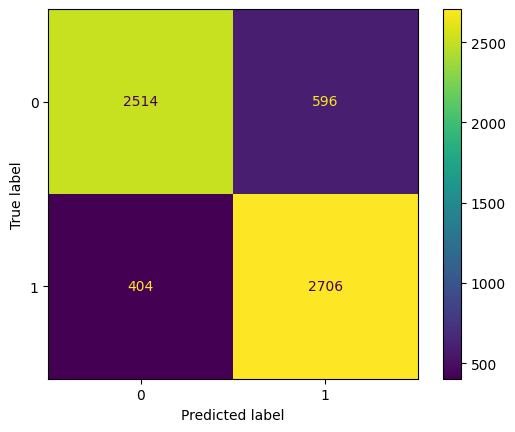

In [62]:
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.savefig("../img/confusion_matrices/confusion_matrix_mlpc_gridsearch_84_acc.png")
plt.show()

In [63]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.86      0.81      0.83      3110
           1       0.82      0.87      0.84      3110

    accuracy                           0.84      6220
   macro avg       0.84      0.84      0.84      6220
weighted avg       0.84      0.84      0.84      6220



### Learning curves

In [53]:
clf["classifier"].best_params_

{'alpha': 0.001, 'hidden_layer_sizes': (100,)}

/home/marouan/.local/share/virtualenvs/NN_project-jQMrRvsR/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/marouan/.local/share/virtualenvs/NN_project-jQMrRvsR/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/marouan/.local/share/virtualenvs/NN_project-jQMrRvsR/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/marouan/.local/share/virtualenvs/NN_project-jQMrRvsR/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochas

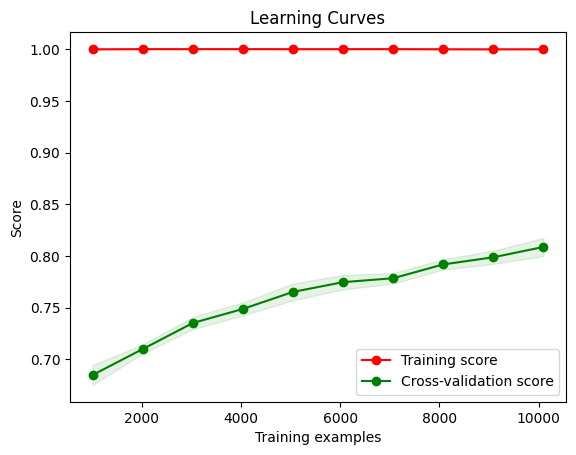

In [54]:
model = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", MLPClassifier(random_state=42, alpha=clf["classifier"].best_params_["alpha"], hidden_layer_sizes=clf["classifier"].best_params_["hidden_layer_sizes"]))]
)

# Define the learning curve function
train_sizes, train_scores, validation_scores = learning_curve(
    estimator = model, 
    X = X_train, 
    y = y_train, 
    train_sizes = np.linspace(0.1, 1.0, 10), 
    cv = 5, 
    scoring = 'accuracy',
    n_jobs=5
)

# Calculate the mean and standard deviation of the training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# Plot the learning curves
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curves")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.savefig("../img/learning_curves/learning_curves_mlpc_gridsearch_84_acc.png")
plt.show()

### Export the pipeline in joblib format

In [55]:
# dump(clf, "../assets/mlpc_clf_gridsearch_84_acc.joblib")

['../assets/mlpc_clf_gridsearch_84_acc.joblib']

# Logistic regression

Previous models have a great gap between learning curves, let's find out if using a simpler model could correct this.

### Pipeline definition and training

In [7]:
numeric_features = ["rank_home", "total_points_home", "rank_away", "total_points_away", "home_goals_avg", "away_goals_avg", "home_win_avg", "away_win_avg", "home_last_wins", "away_last_wins"]
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_features = ["home_team", "away_team", "neutral", "confederation_home", "confederation_away"]
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown='ignore')),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(random_state=42))]
)

clf.fit(X_train, y_train)

c:\Users\33650\.virtualenvs\Football_match_results_predictor-8wuK-vSV\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['rank_home',
                                                   'total_points_home',
                                                   'rank_away',
                                                   'total_points_away',
                                                   'home_goals_avg',
                                                   'away_goals_avg',
                                                   'home_win_avg',
                                                   'away_win_avg',
                                                   'home_last_wins',
                                                   'away_last_wins']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['home_team', 'away_team',
                                                   'neutral',
                                                   'confederation_home',
                                                   'confederation_away'])])),
                ('classifier', LogisticRegression(random_state=42))])

### Model evaluation

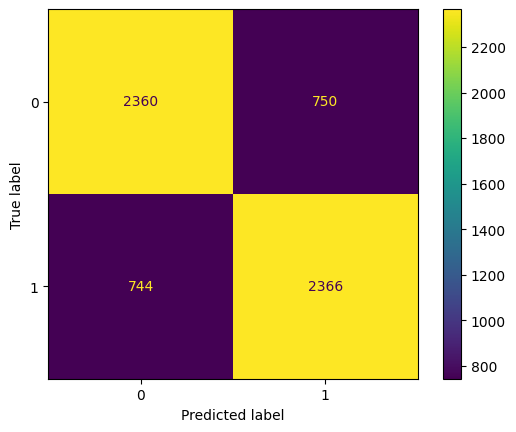

In [8]:
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.savefig("../img/confusion_matrices/confusion_matrix_logistic.png")
plt.show()

In [9]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      3110
           1       0.76      0.76      0.76      3110

    accuracy                           0.76      6220
   macro avg       0.76      0.76      0.76      6220
weighted avg       0.76      0.76      0.76      6220



In [11]:
#dump(clf, "../assets/logistic_regression.joblib")

['../assets/logistic_regression.joblib']

### Learning curves

Let's have a look at the learning curves to see if we have the same trend as previous more complex models.

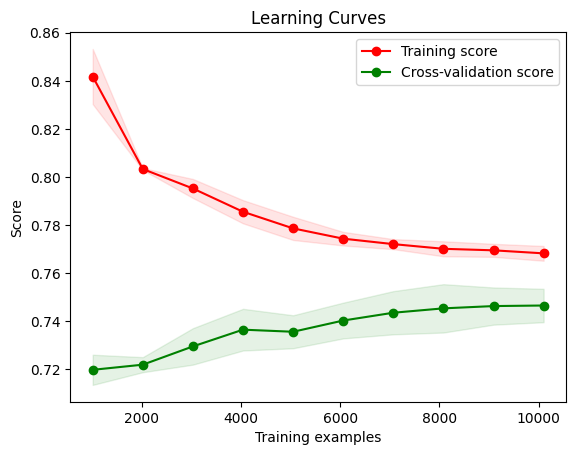

In [10]:
# Define the learning curve function
train_sizes, train_scores, validation_scores = learning_curve(
    estimator = clf, 
    X = X_train, 
    y = y_train, 
    train_sizes = np.linspace(0.1, 1.0, 10), 
    cv = 5, 
    scoring = 'accuracy',
    n_jobs=5 
)

# Calculate the mean and standard deviation of the training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# Plot the learning curves
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curves")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.savefig("../img/learning_curves/learning_curves_logistic.png")
plt.show()

The gap between the curves is smaller, we're no more suspecting an overfitting, but the scores are also lower. Given the previous learning curves, we know that the training score can be really high, thus one can suspect an underfitting here, suggesting that the model is not good enough to correctly represent the data.

# Observations

Although accuracy scores are pretty good, all models present a non-negligeable gap between train and validation learning curves, suggesting a potential overfitting.  
As a consequence, the model may not be able to generalize well. 
   
Hyperparameters fine-tuning did not help reduce the gap between learning curves, nor did it improve the accuracy.  
  

As there is no difference between all models regarding the gap between learning curves, we choose the model with the highest accuracy: Random Forest with optimized hyperparameters ("rf_clf_gridsearch_86_acc.joblib").

**Note**: MLPC model size is much smaller than Random Forest. But since memory is not really a constraint in our project, we still choose Random Forest.

In [56]:
file_name = "../assets/rf_clf_gridsearch_86_acc.joblib"

file_stats = os.stat(file_name)

print(f'Random Forest Size in MegaBytes is {file_stats.st_size / (1024 * 1024)}')

Random Forest Size in MegaBytes is 48.84951972961426


In [57]:
file_name = "../assets/mlpc_clf_gridsearch_84_acc.joblib"

file_stats = os.stat(file_name)

print(f'MLPC Size in MegaBytes is {file_stats.st_size / (1024 * 1024)}')

MLPC Size in MegaBytes is 1.0056781768798828
